In [1]:
import scanpy as sc

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import glob
import scipy
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
sc.set_figure_params(figsize=(5,5)) # no blurry figures allowed
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')


In [4]:
import sys
sys.path.append('./code/')
sys.path.append('../../code/')
import pybedtools as pbt

%load_ext autoreload
%autoreload 2

In [5]:
from aux_functions import *
# from old_make_figures import *
from get_lfcs import generate_lfcs
from plotting_functions import *
import matplotlib.gridspec as gridspec

from aux_functions import *

peak_genes = add_chr_to_bedtool(pbt.BedTool('../../peaks/RNA_coverage.narrowPeak'))

plt.rcParams['pdf.fonttype'] = 42

In [6]:
PATH_TO_ADATA = '/Genomics/argo/users/gdolsten/pritlab/wei_tir1_project/AID02_scRNAseq-selected/AID02_processed.h5ad'

In [7]:
full_rna_adata = sc.read_h5ad(PATH_TO_ADATA)

In [8]:
from gseapy import Msigdb
import gseapy as gp

msig = Msigdb()
gmt = gp.read_gmt('/Genomics/argo/users/gdolsten/pritlab/genesets/msigdb.v2024.1.Mm.symbols.gmt')

In [9]:
def compute_residuals(ad):
    gene_means = pd.DataFrame()
    for theta in [10]: # [0.1, 1, 10, 100, 1000]: ## try different values for theta
        ad.X = np.asarray(ad.layers["counts"].copy().todense())
        sc.experimental.pp.normalize_pearson_residuals(ad, theta = theta, inplace = True)
        lay = "theta_"+ str(round(theta, 1))
        ad.layers[lay] = ad.X.copy()

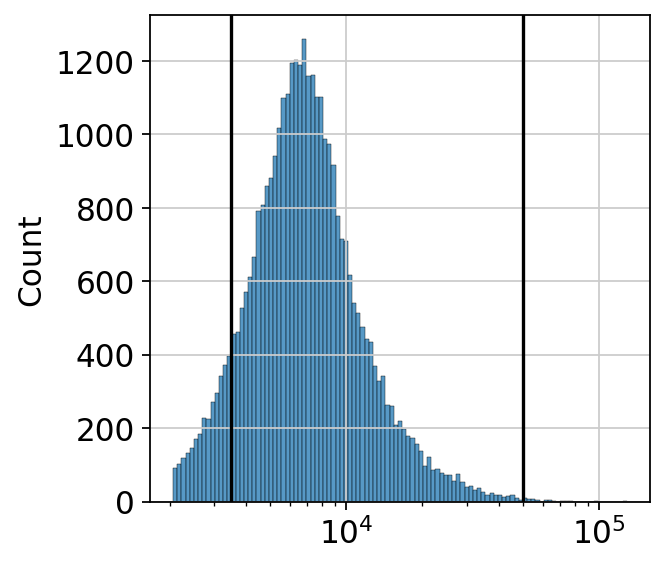

In [10]:
sns.histplot(np.ravel(full_rna_adata.layers['counts'].sum(axis=1)), log_scale = True)
plt.axvline(3.5e3, color='black')
plt.axvline(5e4, color='black')

cells_passing_qc = (np.ravel(full_rna_adata.layers['counts'].sum(axis=1)) > 3.5e3) & (np.ravel(full_rna_adata.layers['counts'].sum(axis=1)) < 5e4)
rna_adata_tumor = full_rna_adata[cells_passing_qc, :].copy()

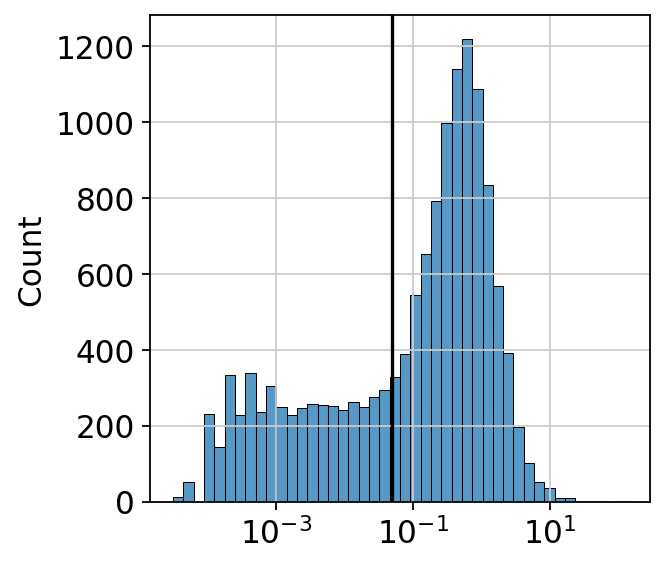

In [11]:
sns.histplot(np.ravel(rna_adata_tumor.layers['counts'].mean(axis=0)), log_scale = True)
plt.axvline(5e-2, color='black')
genes_passing_qc = np.ravel(rna_adata_tumor.layers['counts'].mean(axis=0)) > 5e-2
rna_adata_tumor = rna_adata_tumor[:, genes_passing_qc]

In [12]:
rna_adata_tumor.obs['genotype_mouse'] = rna_adata_tumor.obs['genotype'].astype(str) + "_" + rna_adata_tumor.obs['mouse_id'].astype(str)

/tmp/ipykernel_2509879/1913162051.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_adata_tumor.obs['genotype_mouse'] = rna_adata_tumor.obs['genotype'].astype(str) + "_" + rna_adata_tumor.obs['mouse_id'].astype(str)


#### Filter TCR/BCR genes, pseudogenes, and other poorly annotated genes

In [13]:
tcr_bcr_genes = ['Igha', 'Igkc', 'Jchain', 
                 'Trav5-1', 'Trav14d-3-dv8', 'Trav16n', 'Trav14n-3',
                 'Trav7-5', 'Trav13-1', 'Trav14-1', 'Trav4-3', 'Trav12-2', 'Trav14-2',
                 'Trav3-3', 'Trav4-4-dv10', 'Trav5-4', 'Trav6-7-dv9', 'Trav16',
                 'Trav14-3', 'Trav21-dv12', 'Ighd', 'Ighm', 
                 'Trbv1', 'Trbv2', 'Trbv3', 'Trbv12-1', 'Trbv13-1', 'Trbv12-2',
                 'Trbv13-2', 'Trbv13-3', 'Trbv15', 'Trbv16', 'Trbv19', 'Trbv20',
                 'Trbv26', 'Trbv31', 'Ptcra', 'Trdc', 'Iglc1', 'Trgc4',
                 'Trbv5', 'Trbv14', 'Trbv17', 'Trbv23', 'Trbv29', 'Trbv30', 'Trbc1',
                 'Trbc2', 'Trbv4'
            ]

print('Removing: ', rna_adata_tumor.var.index[rna_adata_tumor.var.index.isin(tcr_bcr_genes)].shape, ' TCR/BCR genes')
print('Removing: ', rna_adata_tumor.var.index[rna_adata_tumor.var.index.str.contains("-ps1")].shape, ' "-ps1" genes')
print('Removing: ', rna_adata_tumor.var.index[rna_adata_tumor.var.index.str.contains("Gm")].shape, ' "Gm" genes')

rna_adata_tumor = rna_adata_tumor[:, ~rna_adata_tumor.var.index.isin(tcr_bcr_genes)]

Removing:  (26,)  TCR/BCR genes
Removing:  (0,)  "-ps1" genes
Removing:  (13,)  "Gm" genes


### Subset to tumor; rerun

In [14]:
from aux_functions_scRNA import *

rna_adata_tumor = rna_adata_tumor[rna_adata_tumor.obs['organ']=='tumor'].copy()
compute_residuals(rna_adata_tumor)
n_pcs = 100
sc.tl.pca(rna_adata_tumor, n_comps=n_pcs, svd_solver='arpack')
sc.pp.neighbors(rna_adata_tumor, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
sc.tl.leiden(rna_adata_tumor, resolution = 1)
sc.tl.umap(rna_adata_tumor)

sc.tl.leiden(rna_adata_tumor, resolution = .5, key_added='leiden_res=0.5')
sc.tl.leiden(rna_adata_tumor, resolution = .25, key_added='leiden_res=0.25')
sc.tl.leiden(rna_adata_tumor, resolution = 2, key_added='leiden_res=2')
sc.tl.leiden(rna_adata_tumor, resolution = 3, key_added='leiden_res=3')

computing analytic Pearson residuals on adata.X
    finished (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/g

    computed neighbors (0:00:43)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res=0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res=0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 41 clusters and added
    'leiden_res=2', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 50 clusters and added
    'leiden_res=3', the cluster labels (adata.obs, categorical) (0:00:01)


In [15]:
leiden_map = {
    '0' : 'Cxcr3+ Treg',
    '1' : 'Gata3+ Th2-like Treg',
    '2' : 'Tbx21+ Th1-like Treg',
    '3' : 'Dividing',
}

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


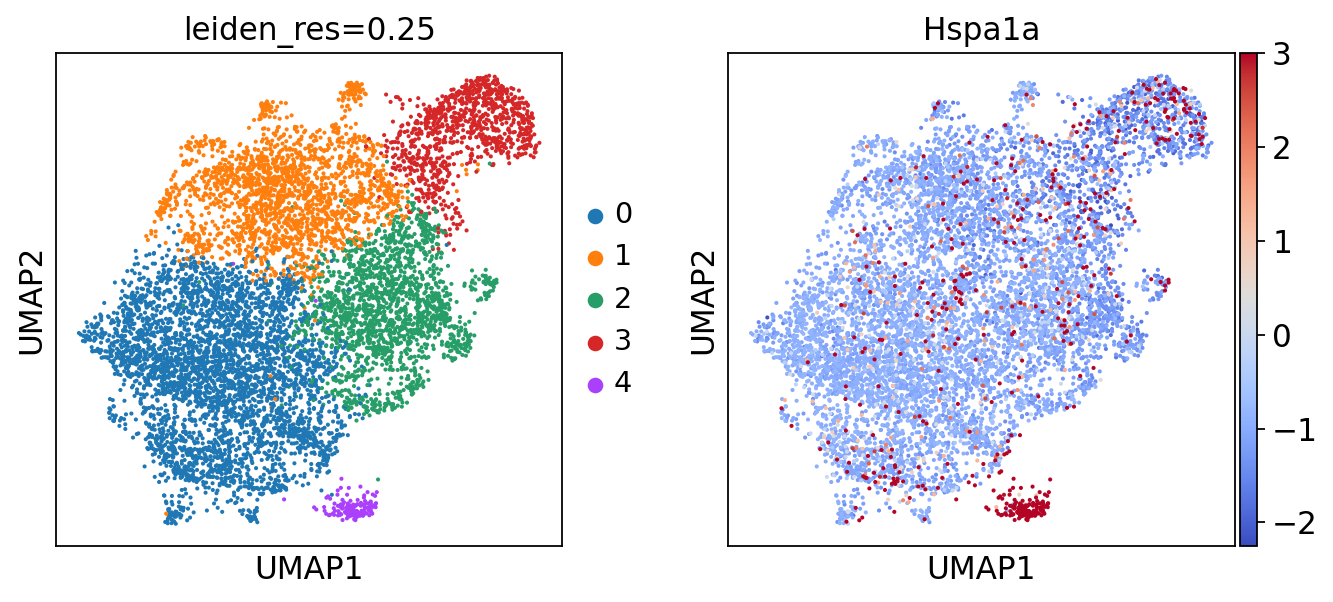

In [16]:
sc.pl.umap(rna_adata_tumor, color=['leiden_res=0.25', 'Hspa1a'], cmap='coolwarm', vmax=3)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


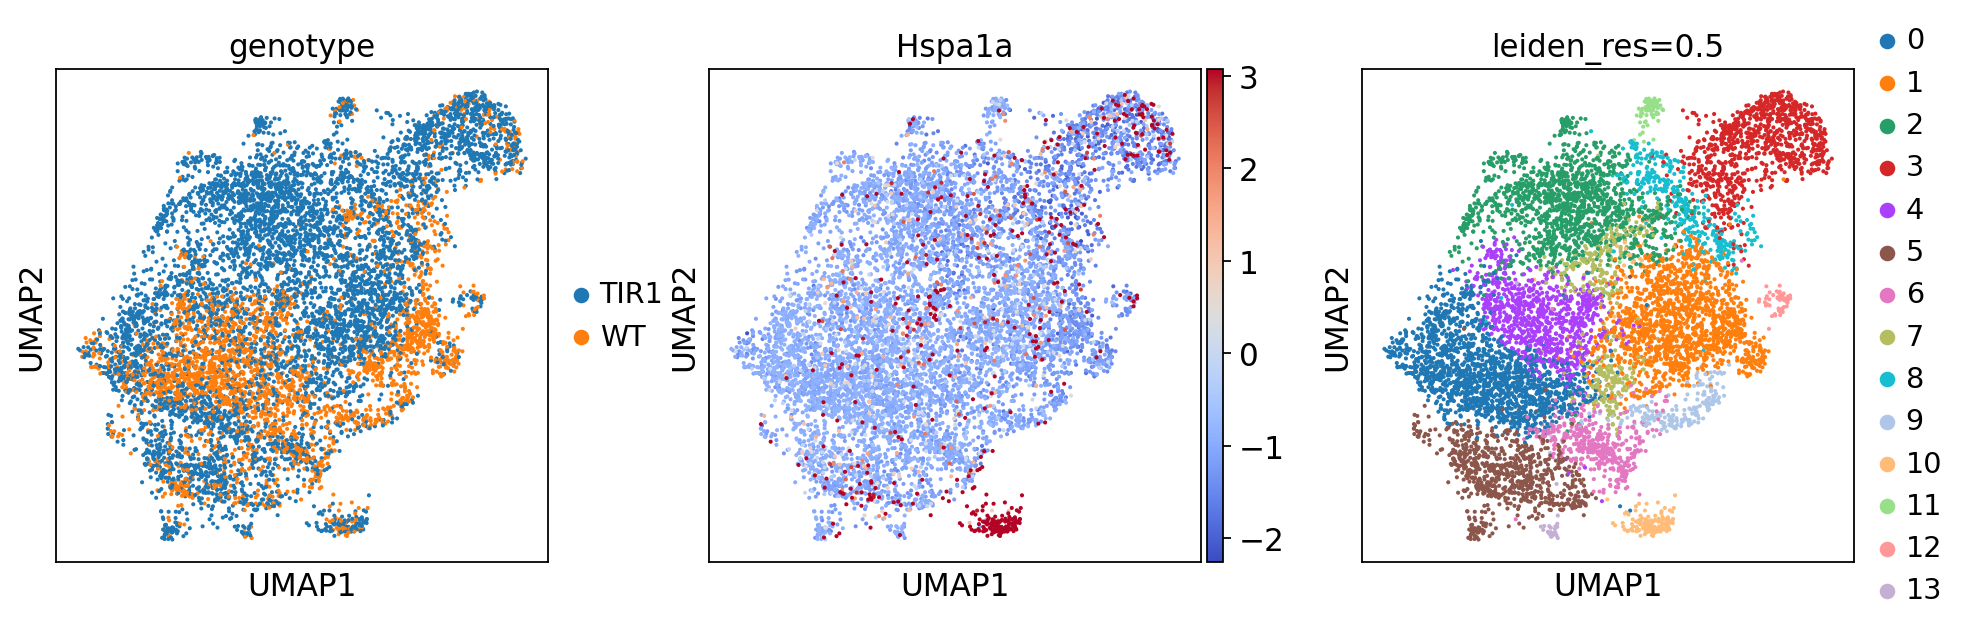

/tmp/ipykernel_2509879/4163973512.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_adata_tumor.obs['leiden_res=0.25'] = rna_adata_tumor.obs['leiden_res=0.25'].astype(str)  # remove old Categorical


In [17]:
# After plotting the UMAP, we observe that one of the clusters is high in Hspa1a and remove it
sc.pl.umap(rna_adata_tumor, color=['genotype', 'Hspa1a', 'leiden_res=0.5'], cmap='coolwarm', vmax='p95')

# Remove outlier cluster (high in heat shock proteins)
rna_adata_tumor = rna_adata_tumor[rna_adata_tumor.obs['leiden_res=0.25'] != '4']

rna_adata_tumor.obs['leiden_res=0.25'] = rna_adata_tumor.obs['leiden_res=0.25'].astype(str)  # remove old Categorical
rna_adata_tumor.obs['leiden_res=0.25'] = rna_adata_tumor.obs['leiden_res=0.25'].apply(leiden_map.get).astype('category')  # recategorize
rna_adata_tumor.obs['cluster_coarse'] = rna_adata_tumor.obs['leiden_res=0.25']

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


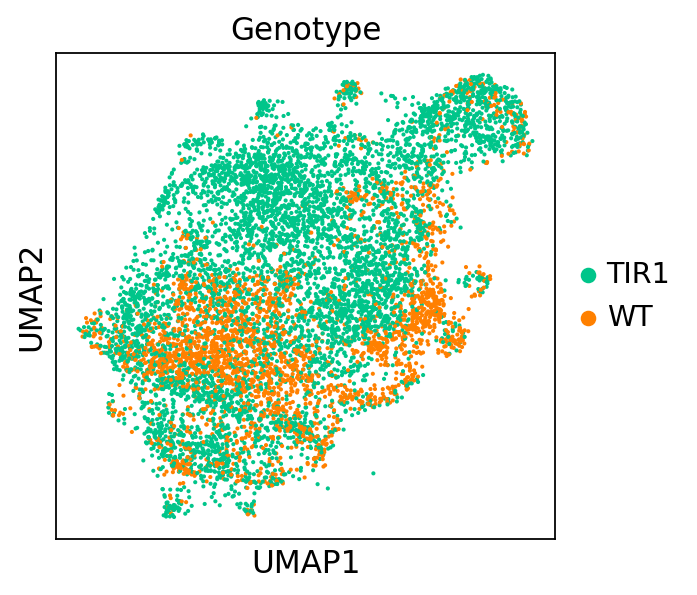

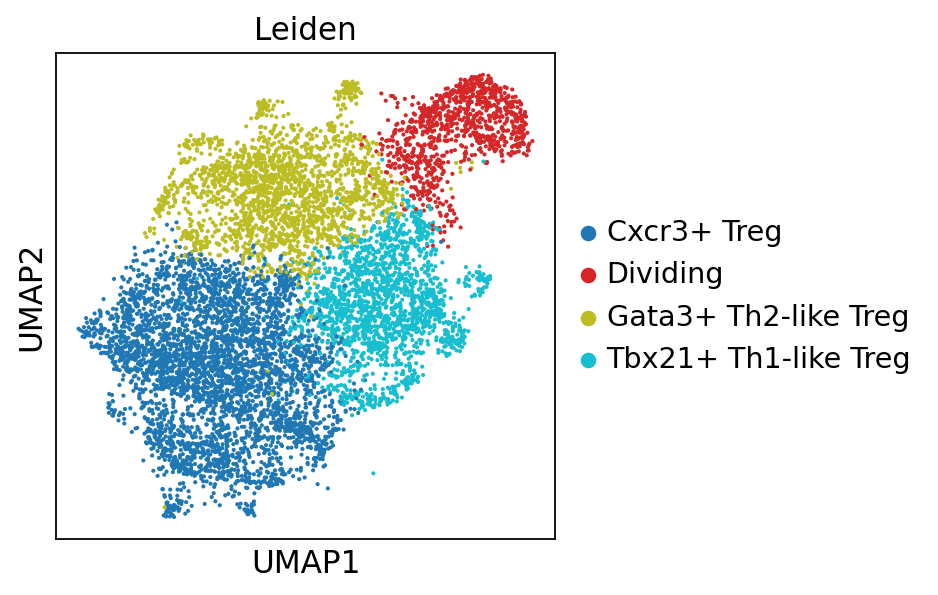

In [18]:
rna_adata_tumor.uns['leiden_res=0.25_colors'] = [sns.color_palette('tab20')[0], 
                                                 sns.color_palette('tab20')[3*2], 
                                                 sns.color_palette('tab20')[8*2],
                                                 sns.color_palette('tab20')[9*2]
                                                ]
rna_adata_tumor.uns['genotype_colors'] = ['#00C58A', '#FF8000']

fig = sc.pl.umap(rna_adata_tumor, color=['genotype'], return_fig=True, title='Genotype')
fig.savefig('./FINAL_FIGURES/tumor/umap_genotype.pdf', dpi = 500, bbox_inches='tight')

fig = sc.pl.umap(rna_adata_tumor, color=['leiden_res=0.25'], return_fig=True, title='Leiden',)
fig.savefig('./FINAL_FIGURES/tumor/umap_clusters.pdf', dpi = 500, bbox_inches='tight')

#### Rerun after dropping Leiden 10

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


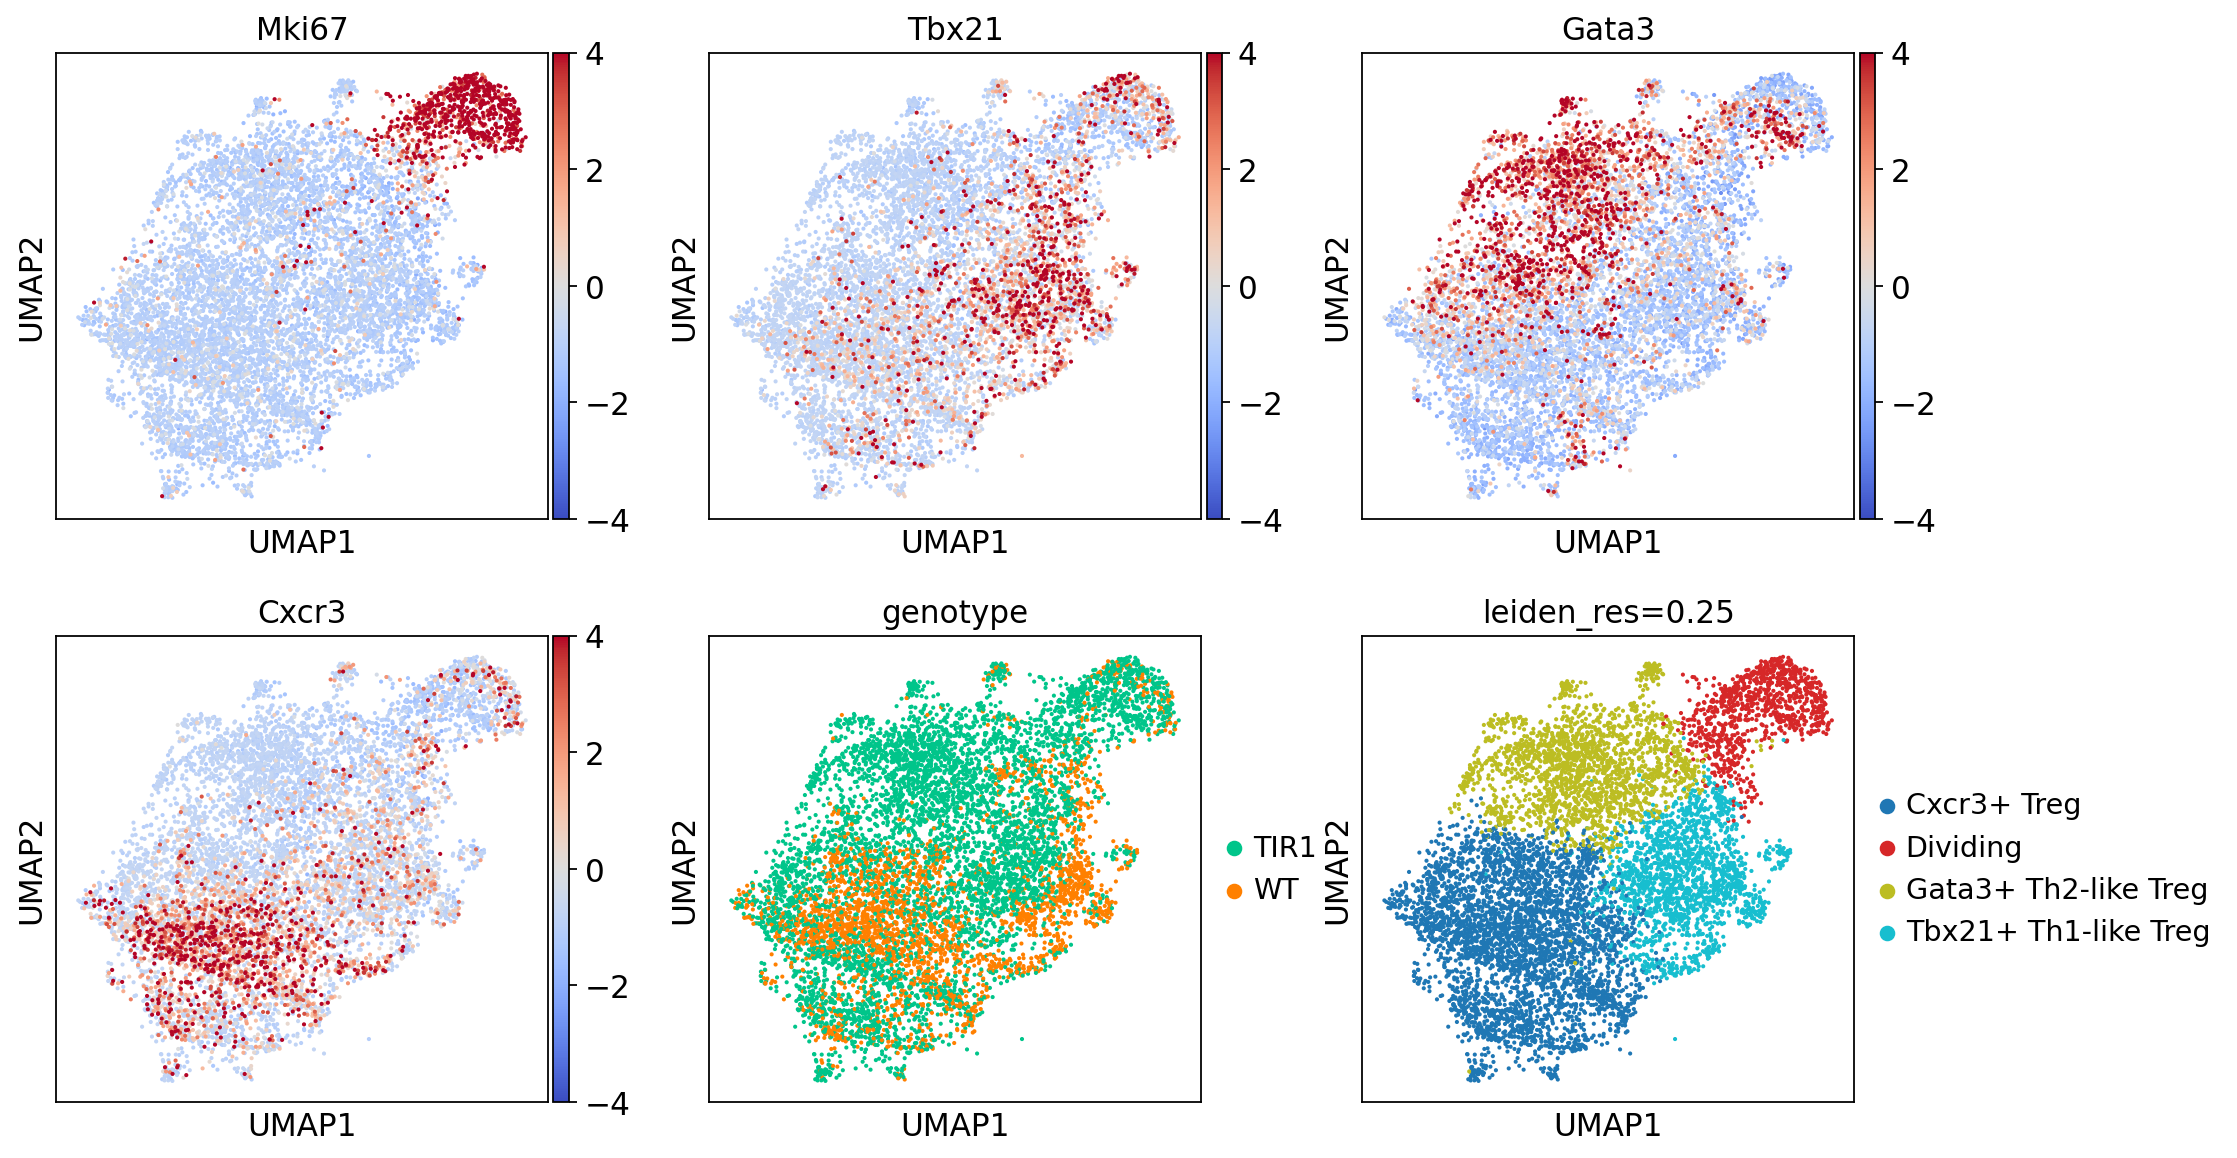

In [19]:
sc.pl.umap(rna_adata_tumor, color=['Mki67', 'Tbx21', 'Gata3', 'Cxcr3',
                                   'genotype', 'leiden_res=0.25', 
                                  ],
           cmap='coolwarm', vmax=4, vmin=-4,
          ncols = 3)

In [20]:
genedict = {
    'Dividing' : ['Mki67',  'Mcm2', 'Top2a', 'H1f5', 'Ccnb2',  'Stmn1',],
    'Cxcr3+' :   ['Cxcr3', 'Cxcr4', 'Klf2', 'Il7r',  'Rorc', ],
    'Th2' :      ['Il4', 'Il5', 'Gata3', 'Ccr7', ],
    'Th1' :      ['Ifng', 'Tbx21', 'Tnf',],
    'Others' :   ['Foxp3', 'Ctla4', 'Entpd1', 'Tnfrsf18', 'Il2ra', ]
}



In [21]:
!mkdir -p FINAL_FIGURES/tumor

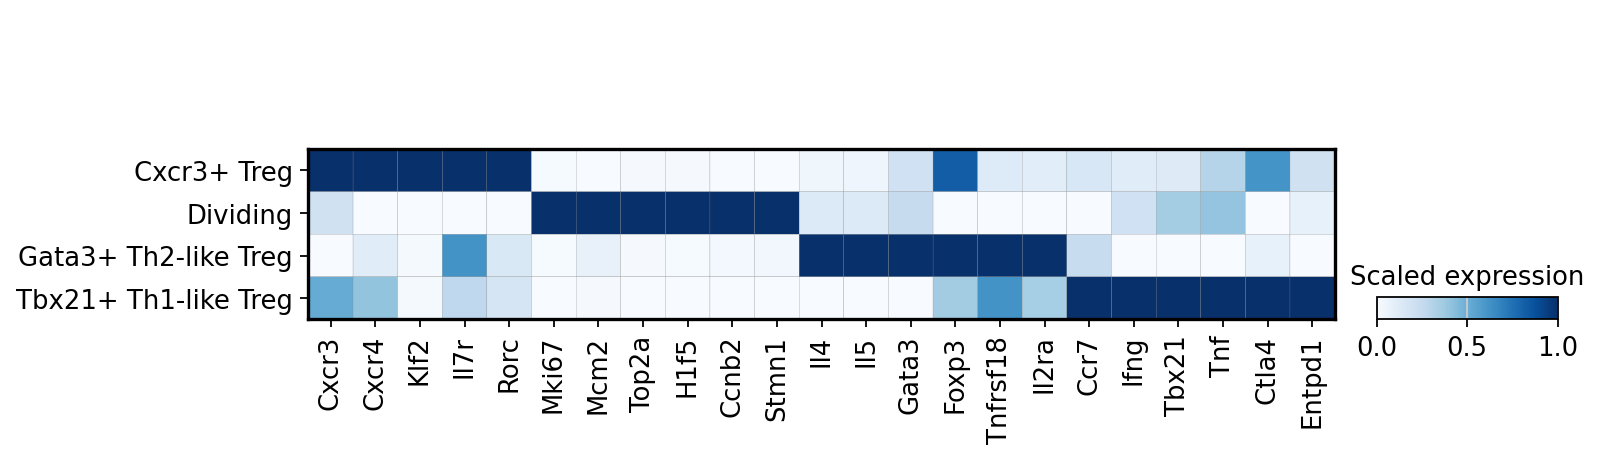

In [22]:
fig = sc.pl.matrixplot(
    rna_adata_tumor,
    [
         'Cxcr3', 'Cxcr4', 'Klf2', 'Il7r',  'Rorc', # Cxcr3+
        'Mki67',  'Mcm2', 'Top2a', 'H1f5', 'Ccnb2',  'Stmn1', # Dividing
        'Il4', 'Il5', 'Gata3', 'Foxp3', 'Tnfrsf18', 'Il2ra',  # Th2-like
         'Ccr7', 'Ifng', 'Tbx21', 'Tnf',  'Ctla4', 'Entpd1', ], # Th1-like
    "leiden_res=0.25",
    # dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="Scaled expression",
    return_fig=True
)
fig.savefig('./FINAL_FIGURES/tumor/matrix_gene_expr.pdf')

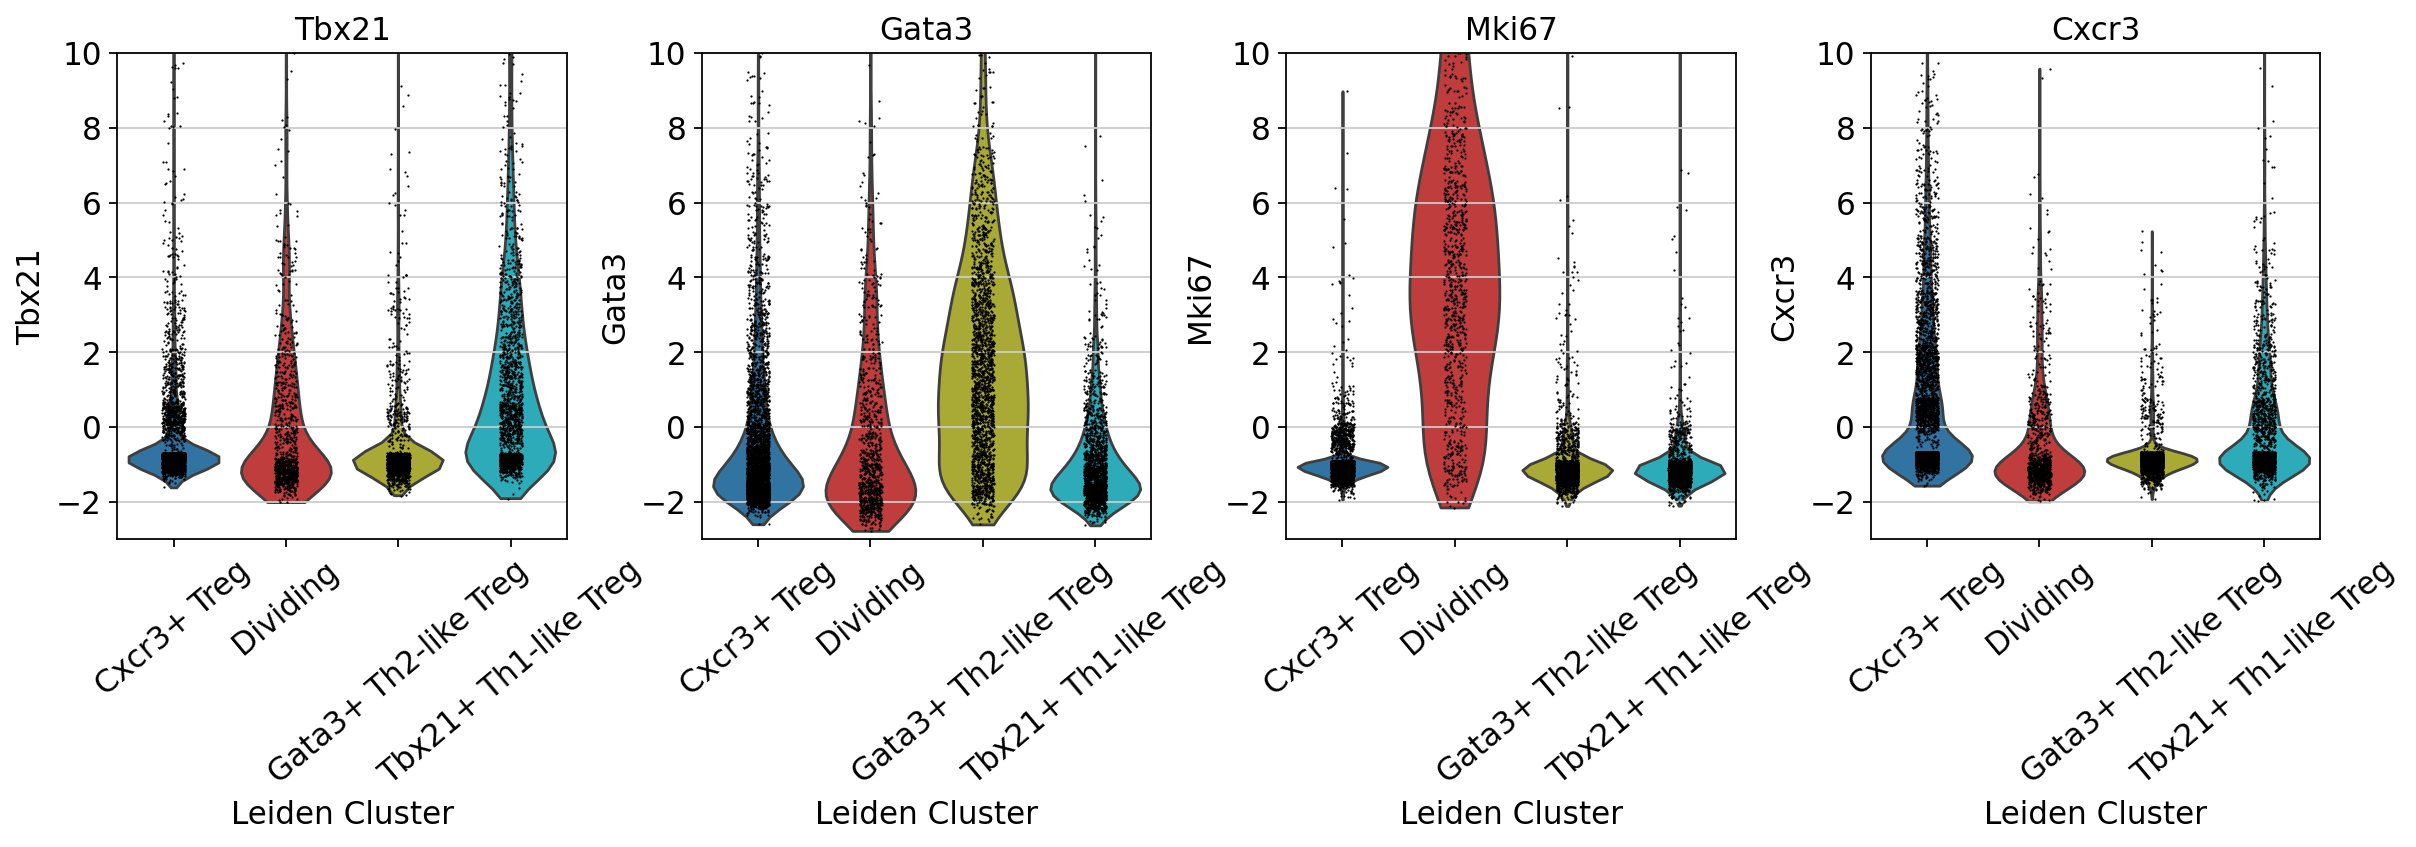

In [23]:
genes = ['Tbx21', 'Gata3', 'Mki67', 'Cxcr3']
ax = sc.pl.violin(rna_adata_tumor, genes, 'leiden_res=0.25', show=False)
for c, a in enumerate(ax):
    a.set_ylim(bottom=-3, top=10)
    a.set_xlabel("Leiden Cluster")
    plt.sca(a)
    plt.xticks(rotation=40)
    plt.title(genes[c])

### Send counts data results to DESeq2

In [24]:
integer_to_leiden = {
    c:u for c, u in enumerate(np.unique(rna_adata_tumor.obs['leiden_res=0.25']))
}

for c, u in enumerate(np.unique(rna_adata_tumor.obs['leiden_res=0.25'])):
    idx = rna_adata_tumor.obs['leiden_res=0.25']==u
    v = aggregate_adata_by_obs_column(rna_adata_tumor[idx], key='genotype_mouse', layer='counts', agg_func=np.sum).astype(int)
    v.to_csv(f'/Genomics/argo/users/gdolsten/pritlab/wei_tir1_project/tumor/Leiden_DESeq2/Tumor.leiden_res=0.25.{c}.csv')

### Load DESeq2 Results

In [25]:
def make_tumor_dfs_leiden_res_025():
    pref = '/Genomics/argo/users/gdolsten/pritlab/jupys/tregs/rudensky_scrna/prelim-analysis/bulk_rna_data/DESeq2/'
    lfc_dfs_tumor = []
    padj_dfs_tumor = []
    base_dfs_tumor = []
    pval_dfs_tumor = []
    normcounts_tumor = []
    walds_tumor = []
    tumor_dfdict = {}
    for cluster in range(4):
        cluster = str(cluster)
        data = pd.read_csv(pref + f'output/TumorLN.Tumor.Leiden_res=0.25.{cluster}_TIR1_vs_WT_thresh=0.csv', sep=' ')
        lfc_dfs_tumor.append(pd.Series(data['log2FoldChange'], name=cluster))
        pval_dfs_tumor.append(pd.Series(data['pvalue'], name=cluster))
        padj_dfs_tumor.append(pd.Series(data['padj'], name=cluster))
        base_dfs_tumor.append(pd.Series(data['baseMean'], name=cluster))
        walds_tumor.append(pd.Series(data['stat'], name=cluster))

        normcounts = pd.read_csv(pref + f'norm_counts/TumorLN.Tumor.Leiden_res=0.25.{cluster}_TIR1_vs_WT.csv', sep=' ')
        normcounts_tumor.append(normcounts)
        tumor_dfdict[cluster] = data
    lfc_dfs_tumor = pd.concat(lfc_dfs_tumor, axis=1)
    padj_dfs_tumor = pd.concat(padj_dfs_tumor, axis=1).fillna(1)
    base_dfs_tumor = pd.concat(base_dfs_tumor, axis=1).fillna(1)
    pval_dfs_tumor = pd.concat(pval_dfs_tumor, axis=1).fillna(1)
    walds_tumor = pd.concat(walds_tumor, axis=1).fillna(1)

    return lfc_dfs_tumor, padj_dfs_tumor, walds_tumor, base_dfs_tumor, pval_dfs_tumor, normcounts_tumor, tumor_dfdict

In [26]:
(lfc_dfs_tumor_025, padj_dfs_tumor_025, wald_dfs_tumor_025, base_dfs_tumor_025, 
    pval_dfs_tumor_025, normcounts_tumor_025, tumor_dfdict_025) = make_tumor_dfs_leiden_res_025()

### Save Cluster Abundances as Table

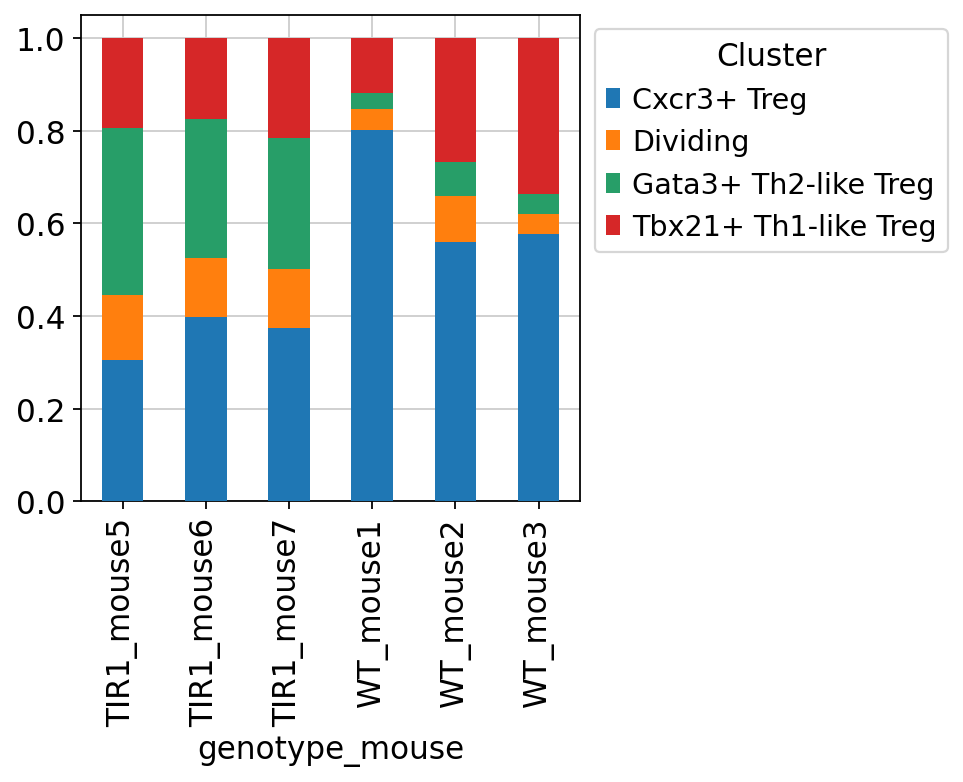

In [27]:
fractions = rna_adata_tumor.obs.groupby('leiden_res=0.25')['genotype_mouse'].value_counts().unstack()
fractions = fractions / fractions.sum(axis=0)
fractions.to_csv('./FINAL_FIGURES/tumor/leiden_cluster_fractions.csv')
fractions.T.plot.bar(stacked=True, zorder=3)
plt.legend(bbox_to_anchor=(1, 1), title='Cluster')

### Plot as volcanos

In [30]:
lfc_dfs_tumor_025.columns = [leiden_map[x] for x in padj_dfs_tumor_025]
padj_dfs_tumor_025.columns = [leiden_map[x] for x in padj_dfs_tumor_025]

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


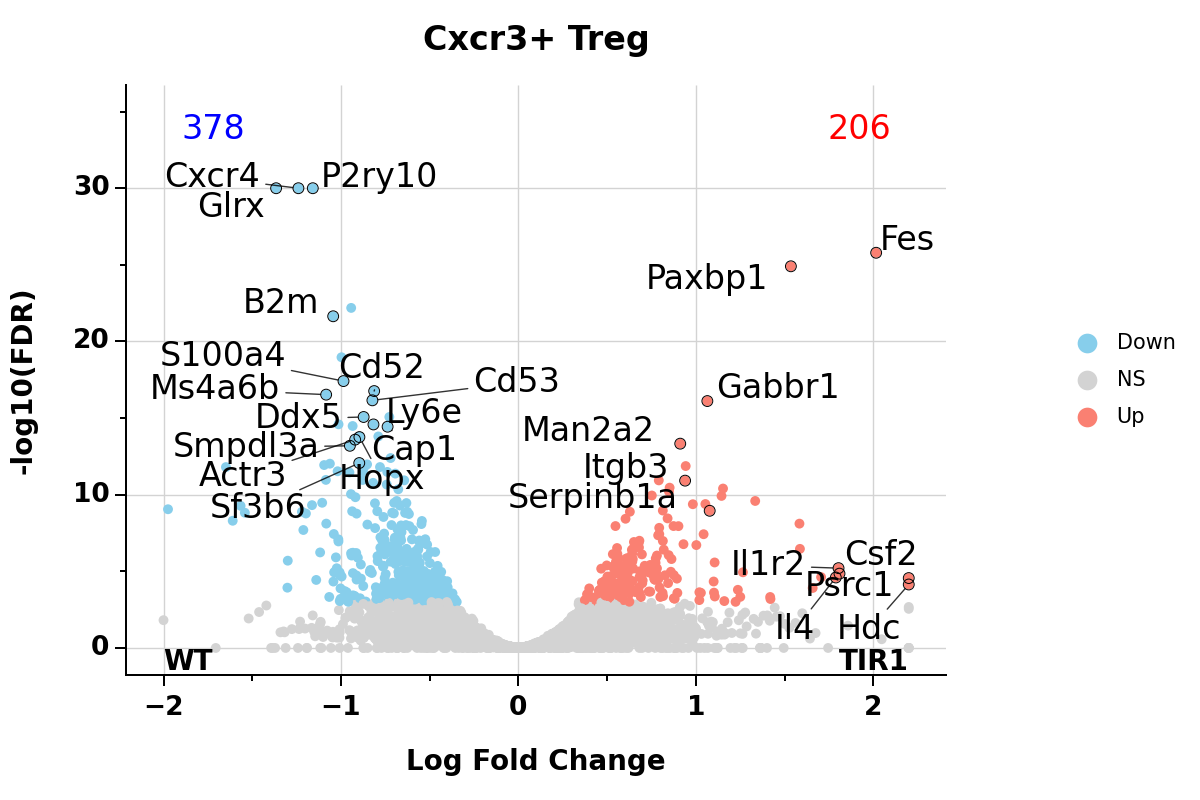

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./FINAL_FIGURES/tumor/Cxcr3+_Treg.pdf
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


In [31]:
from plotnine_plotting_functions import volcano_plot_plotnine
from plotnine import *

col = 'Cxcr3+ Treg'
plot = volcano_plot_plotnine(lfc_dfs_tumor_025[col].clip(-5, 5),
             padj_dfs_tumor_025[col].fillna(1).clip(1e-300, 1),
             pd.Series(lfc_dfs_tumor_025.index, lfc_dfs_tumor_025.index),
             pco = 1e-3,
             label_pval_cutoff = 12,
             max_y = 30,
             _ylim = [0, 35],
             _xlim=[-2, 2.2],
             s = 2,
             title = col,
             genes_to_label = ['Il3',  'Il4',  'Il1r2',  'Csf2', 'Serpinb1a', 'Itgb3', 'Psrc1',  'Hdc',
                              ],
                             xL = 'WT',
                             xR = 'TIR1',
                             ignore_set={'mt-Nd1', 'Trac', 'Sfr1', 'Selenop', 'Dazap2', 'Arhgdib', 'Flna', 'Arf4', 'Tmem123'}
)
print(plot)
plot.save(f'./FINAL_FIGURES/tumor/{col.replace(" ", "_")}.pdf', bbox_inches='tight')

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 61 rows containing missing values.


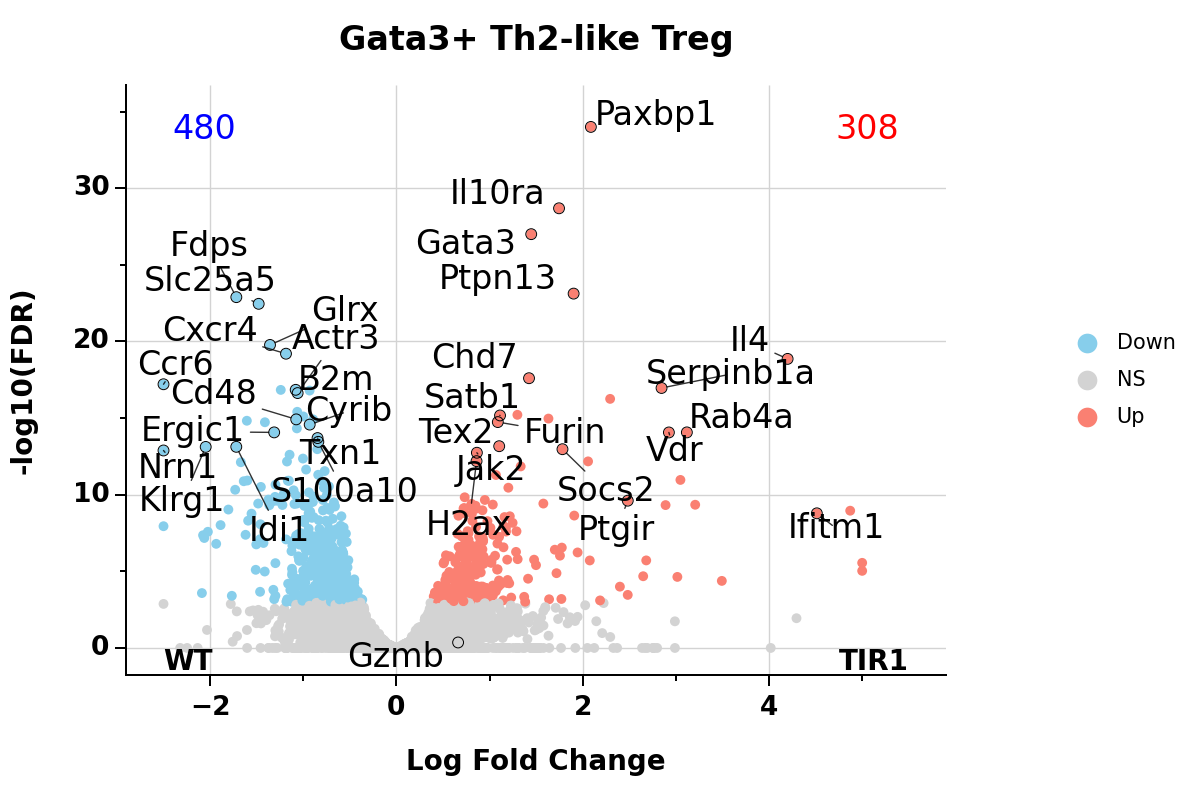

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./FINAL_FIGURES/tumor/Gata3+_Th2-like_Treg.pdf
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 61 rows containing missing values.


In [32]:
from plotnine_plotting_functions import volcano_plot_plotnine
from plotnine import *

col = 'Gata3+ Th2-like Treg'
plot = volcano_plot_plotnine(lfc_dfs_tumor_025[col].clip(-5, 5),
             padj_dfs_tumor_025[col].fillna(1).clip(1e-300, 1),
             pd.Series(lfc_dfs_tumor_025.index, lfc_dfs_tumor_025.index),
             pco = 1e-3,
             label_pval_cutoff = 12,
             max_y = 34,
             _ylim = [0, 35],
             _xlim=[-2.5, 5.5],
             s = 2,
                             xL = 'WT',
                             xR = 'TIR1',
             title = col,
             genes_to_label = [ 'Serpinb1a', 'Cll4', 'Ptgir', 'Ifitm1', 'Ccr6', 'Gzmb'],
             ignore_set={'mt-Nd1', 'Trac', 'Sfr1', 'Selenop', 'Dazap2', 'Arhgdib',
                                        'Flna', 'Erp44', 'Aida', 'Naca', 'Uqcrc2', 'Capg',
                                        'Zfyve16', 'Lgals7', 'Ramp3', 'Pik3ap1', 'Septin7',
                                        'Ctsb', 'Hmgcs1', 'Gimap7', 'Sf3b6', }
)
print(plot)
plot.save(f'./FINAL_FIGURES/tumor/{col.replace(" ", "_")}.pdf', bbox_inches='tight')

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


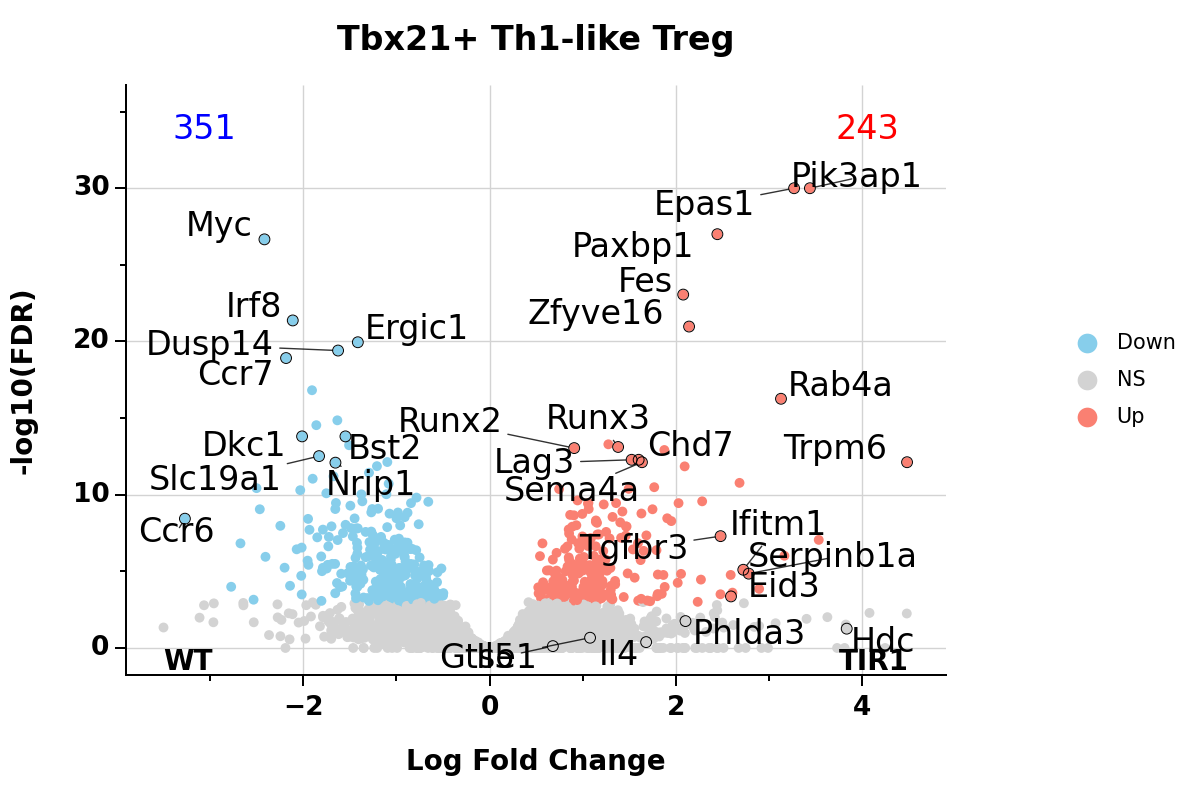

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./FINAL_FIGURES/tumor/Tbx21+_Th1-like_Treg.pdf
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


In [33]:
from plotnine_plotting_functions import volcano_plot_plotnine
from plotnine import *

col = 'Tbx21+ Th1-like Treg'
plot = volcano_plot_plotnine(lfc_dfs_tumor_025[col].clip(-5, 5),
             padj_dfs_tumor_025[col].fillna(1).clip(1e-300, 1),
             pd.Series(lfc_dfs_tumor_025.index, lfc_dfs_tumor_025.index),
             pco = 1e-3,
             label_pval_cutoff = 12,
             max_y = 30,
             _ylim = [0, 35],
             _xlim=[-3.5, 4.5],
             s = 2,
                             xL = 'WT',
                             xR = 'TIR1',
                             fontsize=12,
             title = col,
             genes_to_label = [ 'Serpinb1a', 'Cll4',  'Ifitm1',  'Hdc',
                              'Ccr6', 'Il5', 'Il4', 'Ifitm1', 'Tgfbr3', 'Phlda3', 'Gtse1', 'Eid3', 
                               'Runx2',
                               
                              ],
             
                             # genes_to_label = [ 'Serpinb1a', 'Cll4', 'Ptgir', 'Ifitm1', 'Ccr6', 'Gzmb'],
             ignore_set={'mt-Nd1', 'Trac', 'Sfr1', 'Selenop', 'Dazap2', 'Arhgdib', 'Flna', 
                         'Erp44', 'Aida', 'Naca', 'Uqcrc2', 'Capg', 'Gpsm3', 'Ptpn13', 'Plek', 
                         'Pno1', 'Pa2g4', 'Ppa1'},
)
print(plot)
plot.save(f'./FINAL_FIGURES/tumor/{col.replace(" ", "_")}.pdf', bbox_inches='tight')